# Question and summary

By automatically identifying the boundaries and regions of specific anatomical structures or areas of interest/pathology, image segmentation plays a crucial role in many medical imaging applications. For improved planning, monitoring, and visualisation of illness progression, accurate segmentation can greatly help clinicians in their diagnostic process.

How can we use a convolutional neural network to automatically segregate regions of interest in medical grayscale images?

Data source:A collection of X-ray and CT scan images from the "COVID-19 Radiography Database" on Kaggle are arranged into categories such COVID, viral pneumonia, lung opacity, and normal conditions. The dataset helps train machine learning models to recognise and differentiate between various lung-related illnesses in the context of the COVID-19 pandemic. It was primarily created for study in medical imaging. When using a dataset, it's important to credit the source and follow the licencing requirements.

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

/Applications/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras import regularizers

In [3]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array


# Loading and preprocessing  xray

In [4]:
#directory path for images and masks
dataset_images  = "/Users/abdullrahmannawasrah/Desktop/images"
mask_dataset = "/Users/abdullrahmannawasrah/Desktop/masks"

#Create a list of sorted image  and mask file
image_files = sorted([os.path.join(dataset_images, file) for file in os.listdir(dataset_images)])
mask_files = sorted([os.path.join(mask_dataset, file) for file in os.listdir(mask_dataset)])
#Each image and  mask file are loaded, scaled to 128x128 pixels, turned into grayscale, and then stored as an array
images = [img_to_array(load_img(img, target_size=(128, 128), color_mode="grayscale")) for img in image_files]
masks = [img_to_array(load_img(img, target_size=(128, 128), color_mode="grayscale")) for img in mask_files]

#Convert the list of image and masks arrays into a numpy
images = np.array(images) / 255
masks = np.array(masks) / 255

In [5]:
from tensorflow.keras.layers import Dense, Flatten, Reshape, Input, Conv2D, MaxPooling2D, UpSampling2D


# Building the CNN model for segmentation

In [13]:
from keras.layers import Conv2D, MaxPooling2D, UpSampling2D

model = Sequential()

#encoding layers
# include the'same' padding, a 2D convolution layer with 32 filters, a 3x3 kernel, and ReLU activation
model.add(Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(128, 128, 1)))
#add a 2D Max pooling layer with a pool size of 2x2 and'same' padding to cut the spatial dimensions in half
model.add(MaxPooling2D((2, 2), padding='same'))
# add a second 2D convolution layer with the same padding, 64 filters, a 3x3 kernel, and ReLU activation
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
# increase the number of 2D max pooling layers to further halve the spatial dimensions
model.add(MaxPooling2D((2, 2), padding='same'))

#decoding layers
# include a layer of 2D convolution with 64 filters, a 3x3 kernel, ReLU activation, and the "same" padding
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
# increase the size of the features' upsampling to the original spatial dimensions
model.add(UpSampling2D((2, 2)))
#add a second 2D convolution layer with the same padding, 32 filters, a 3x3 kernel, and ReLU activation
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
#return to the original spatial dimensions after upsampling the features
model.add(UpSampling2D((2, 2)))
#final convolution layer has one filter, a 3x3 kernel, sigmoid activation
model.add(Conv2D(1, (3, 3), activation='sigmoid', padding='same'))
#using the Adam optimizer to build the model, binary crossentropy as the loss function, and tracking accuracy as a statistic
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In order to create a Convolutional Neural Network (CNN) that is especially suited for image segmentation tasks, we apply "#Building the CNN model for segmentation" in this work. The goal of image segmentation is to divide an image into segments or relevant areas. Because CNNs can automatically and adaptively learn the spatial hierarchies of features from the input images, they are quite successful for this kind of work and are well-suited to capture the complex patterns and structures needed for segmentation. By creating a CNN model, you may take advantage of its potent feature extraction powers to obtain accurate segmentation outcomes

# Split dataset and training the model

In [14]:
x_train, x_test, y_train, y_test = train_test_split(images, masks, test_size=0.33, random_state=42)

In [15]:
model.fit(x_train, y_train, epochs=10, batch_size=32, validation_data=(x_test, y_test))


Epoch 1/10
76/76 [==============================] - 162s 2s/step - loss: 0.4685 - accuracy: 0.7610 - val_loss: 0.3824 - val_accuracy: 0.8303
Epoch 2/10
76/76 [==============================] - 183s 2s/step - loss: 0.3599 - accuracy: 0.8478 - val_loss: 0.3203 - val_accuracy: 0.8703
Epoch 3/10
76/76 [==============================] - 171s 2s/step - loss: 0.2692 - accuracy: 0.8920 - val_loss: 0.2371 - val_accuracy: 0.9120
Epoch 4/10
76/76 [==============================] - 149s 2s/step - loss: 0.2207 - accuracy: 0.9123 - val_loss: 0.2089 - val_accuracy: 0.9160
Epoch 5/10
76/76 [==============================] - 145s 2s/step - loss: 0.2019 - accuracy: 0.9206 - val_loss: 0.1862 - val_accuracy: 0.9290
Epoch 6/10
76/76 [==============================] - 141s 2s/step - loss: 0.1876 - accuracy: 0.9266 - val_loss: 0.1704 - val_accuracy: 0.9340
Epoch 7/10
76/76 [==============================] - 159s 2s/step - loss: 0.1777 - accuracy: 0.9308 - val_loss: 0.1855 - val_accuracy: 0.9278
Epoch 8/10
76

# Evaluate the CNN

In [17]:
#using the test dataset to evaluate the model and storing the results as "scores"
model.evaluate(x_test, y_test)

print(f"Test Loss: {scores[0]}\nTest Accuracy: {scores[1]}")

38/38 [==============================] - 20s 536ms/step - loss: 0.1478 - accuracy: 0.9420
Test Loss: 0.14781427383422852
Test Accuracy: 0.9419625997543335


The model was evaluated on a test set over the course of 38 batches, which took about 20 seconds in total. It had an accuracy of 94.20% and a loss value of 0.1478, demonstrating the high calibre of its forecasts and demonstrating its prowess in creating accurate predictions. In conclusion, the model displays solid performance with remarkable accuracy and a loss rate

# VISUALIZATION

1/1 [==============================] - 0s 106ms/step


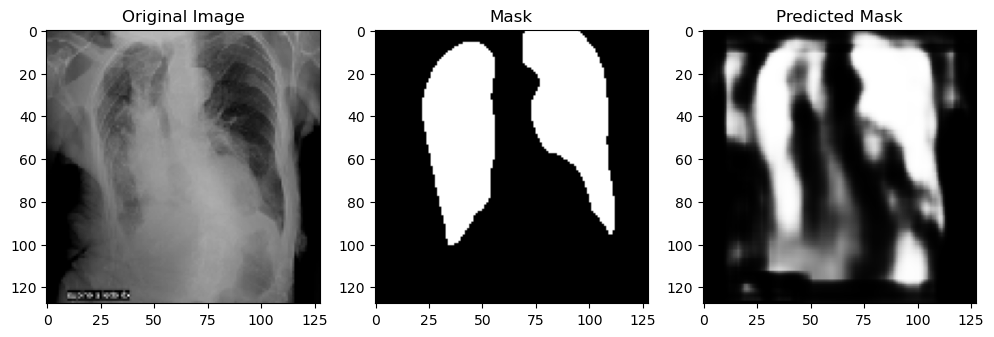

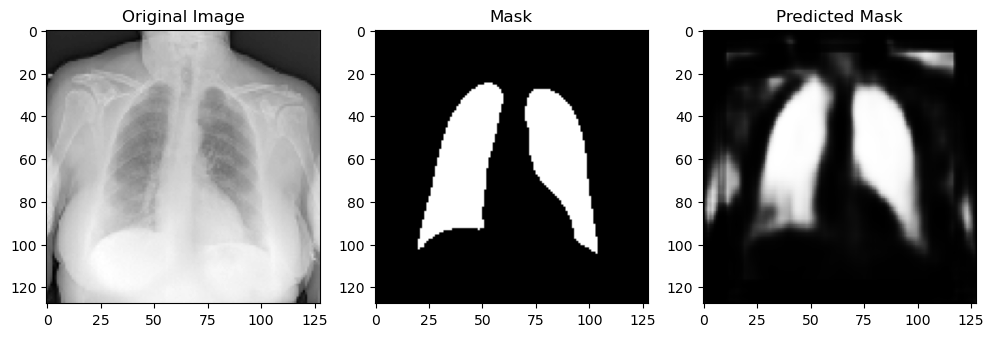

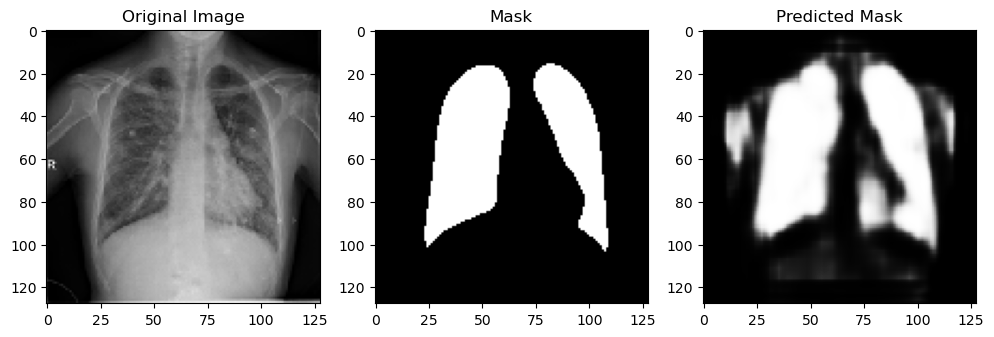

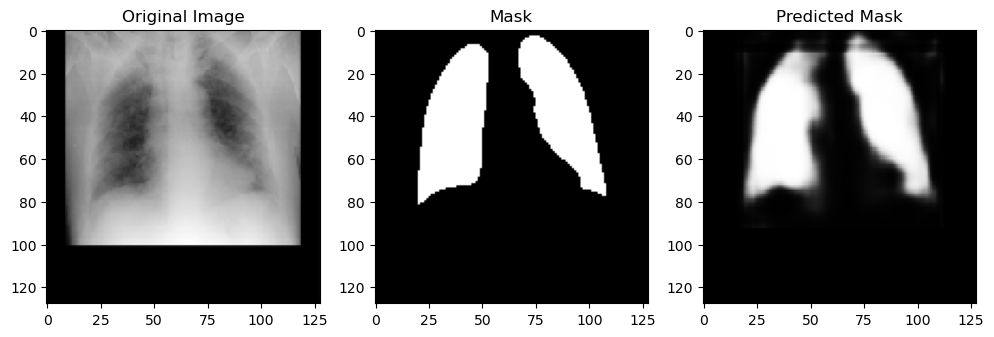

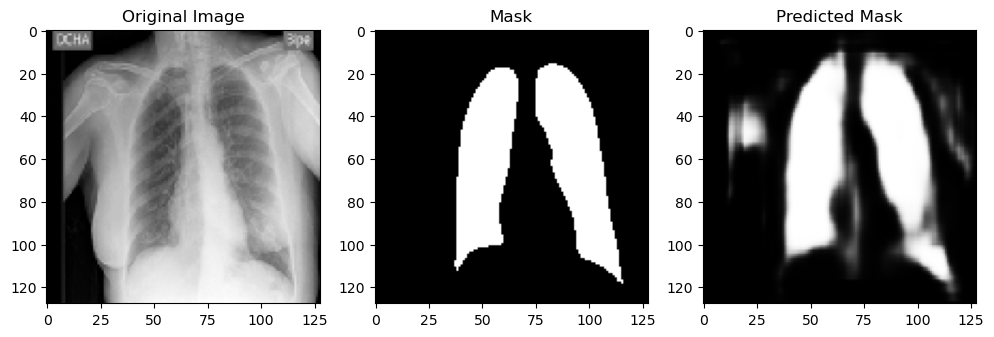

In [19]:
# Predict images from the test set
predicted_masks = model.predict(x_test[:5])
predicted_masks = np.squeeze(predicted_masks, axis=3)

for i in range(5):
    fig, ax = plt.subplots(1, 3, figsize=(12, 6))
    
    # original image
    ax[0].imshow(x_test[i], cmap='gray')
    ax[0].set_title("Original Image")
    
    #  mask
    ax[1].imshow(y_test[i], cmap='gray')
    ax[1].set_title("Mask")
    
    # predicted mask
    ax[2].imshow(predicted_masks[i], cmap='gray')
    ax[2].set_title("Predicted Mask")
    
    plt.show()

Report:Images and their accompanying masks were taken from a local directory during the data preparation phase, scaled to 128x128 pixels, and normalised between 0 and 1 to facilitate model training. Our model used convolutional layers for feature extraction using a CNN architecture, together with MaxPooling for down-sampling and UpSampling for restoration. The dataset, partitioned with 33% set aside for testing, was trained using the Adam optimizer with binary cross-entropy loss, and it produced an accuracy of roughly 94.20% after 10 iterations. A visual evaluation further contrasted the model predictions, masks, and original images to ascertain its efficacy.

Recommendations:We propose many techniques to further improve our model. First, given the steadily increasing validation accuracy, it may be possible to prolong training over additional epochs, albeit it's important to watch out for overfitting. The model's adaptability can be improved by including data augmentation techniques such random rotations and shifts. Exploring a complicated architecture like CNN or employing pre-trained models may be advantageous for datasets with higher levels of complexity or diversity. Last but not least, implementing a learning rate scheduler may hasten model convergence and improve generalisation.